#MP4

In this assignment you will be performing Semantic Segmentation. We've provided the dataset and some helper code to guide you along.

Reminders:
- When first getting your code to run do not use GPU as this will exhaust your colab resources
- When you're ready to properly test your models, make sure you are connected to a GPU runtime as this does significantly speeds up execution
    - To change your runtime do: **Runtime** --> **Change runtime type** --> under **Hardware accelerator** select **GPU**
    - Note that changing runtime resets your kernel (meaning you will need to rerun cells and local variables will be lost)
    - It also sets this new runtime as the default when you return to this notebook later
- Do not start last minute, these models do take some time to train
- Loading the data takes some time, you should only have to do this once

## Accessing the data

There are multiple ways to work with data in colab.
See this [Colab notebook](https://colab.research.google.com/notebooks/io.ipynb) or this [StackOverflow post](https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive) for more details.

Once you've mounted your drive you can see your entire drive file structure by clicking the "Files" tab on the left.

**If you wish to work locally you can ignore the first two cells, but you will still need to set the appropriate path for your dataset**

In [1]:
# Note there are other methods to do this
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
except:
    pass

In [2]:
import os
try:
    if not os.path.exists("/content/gdrive/My Drive/CS_498_MP4"):
        os.makedirs("/content/gdrive/My Drive/CS_498_MP4")
except:
    pass
try:
    os.chdir("/content/gdrive/My Drive/CS_498_MP4")
except:
    pass

# TODO: make sure to specify the right dataset path here
DATASET_PATH = 'data/sbd/'
# DATASET_PATH = '/content/gdrive/MyDrive/CS_498_MP4/data/sbd/'

In [3]:
import glob
import os
import math
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, average_precision_score
import random

from PIL import Image, ImageOps
import torch
from torch import nn
from torch.utils import data
import torchvision
from torchvision import models
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim

/scratch/yerong/local/anaconda3/envs/sw/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset (Q1)

Here we define a class (pytorch Dataset) for accessing data. This allows us to perform transformations on the data (data augmentation) as we access it. Pytorch dataloaders take in a dataset and conventiently deal with the overhead of looping through it in batches. Creating such datasets/loaders significantly simplifies our training code later on.

**PDF: In your pdf visualize the same image (your choice which) a couple times to demonstrate your transformations**



In [4]:
class SegmentationDataset(data.Dataset):
    """
    Data loader for the Segmentation Dataset. If data loading is a bottleneck, 
    you may want to optimize this in for faster training. Possibilities include
    pre-loading all images and annotations into memory before training, so as 
    to limit delays due to disk reads.
    """
    def __init__(self, split="train", preload=True, data_dir=DATASET_PATH, transform=False):
        assert(split in ["train", "val", "test"])
        self.img_dir = os.path.join(data_dir, split)
        self.classes = []
        with open(os.path.join(data_dir, 'classes.txt'), 'r') as f:
            for l in f:
                self.classes.append(l.rstrip())
        self.n_classes = len(self.classes)
        self.split = split
        self.data = glob.glob(self.img_dir + '/*.jpg') 
        self.data = [os.path.splitext(l)[0] for l in self.data]
        self.transform = transform
        self.preload = preload
        # preload data
        if preload:
            self.images = [Image.open(self.data[index] + '.jpg') for index in range(len(self.data))]
            self.ground_truth = [Image.open(self.data[index] + '.png') for index in range(len(self.data))]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        try:
        
            if self.preload:
                img = self.images[index]
                gt = self.ground_truth[index]
            else:
                img = Image.open(self.data[index] + '.jpg')
                gt = Image.open(self.data[index] + '.png')

            # Question 1: data augmentation
            # hint: how does transforming the image affect the ground truth?     
    #         print(max(np.asarray(gt).reshape(-1)), min(np.asarray(gt).reshape(-1)))
            size = img.size
    #         (288, 224)
            if self.transform:
                # Your code
                # -------------------------
                flip_prob = 0.5
                randx = random.uniform(0, 1)

                # hflip vflip
                if randx < flip_prob:
                    img = TF.hflip(img)
                    gt = TF.hflip(gt)

                crop = transforms.RandomResizedCrop(size=img.size, scale=(0.5, 1))
                params = crop.get_params(img, scale=(0.5, 1.0), ratio=(0.75, 1.33))
    #             if params[2]* params[3] < 0.4 * size[0] * size[1] : print(params)
                img = transforms.functional.crop(img, *params)
                gt = transforms.functional.crop(gt, *params)

                img = TF.resize(img, size)
                gt = TF.resize(gt, size)
    #             width, height = img.size
    #             x = random.randrange(width)
    #             y = random.randrange(height)

    #             ratio = height / width

    #             w = random.randrange(max(width-x, math.floor((height-y)/ratio)))
    #             h = math.floor(ratio * w)
    # #             print(ratio, h/w)
    # #             img = img.crop((x, y, x + w, y + h))
    # #             gt = gt.crop((x, y, x + w, y + h))
    #             img = TF.crop(img, x, y, w, h)
    #             gt = TF.crop(gt, x, y, w, h)
    #             img = TF.resize(img, [width, height])
    #             gt = TF.resize(gt, [width, height])


    #                 img = ImageOps.mirror(img)
    #                 gt = ImageOps.mirror(gt)
    #             return img, gt
                # -------------------------

            img = ToTensor()(img)
            gt = torch.LongTensor(np.array(gt)).unsqueeze(0)
        except:
            print(index)
            print(self.data[index] + '.jpg')
        return img, gt

In [5]:
try :
    del dataset
    import gc
    gc.collect()
except: pass

dataset = SegmentationDataset(split="train", preload=True, data_dir=DATASET_PATH, transform=True)

In [6]:
# TODO: set the batch size, when running experiments later you should try different batch sizes
# training_batch_size = None
training_batch_size = 2
dataloader = data.DataLoader(dataset, batch_size=training_batch_size, shuffle=True, num_workers=0, drop_last=True)

In [7]:
try :
    del val_dataset
    import gc
    gc.collect()
except: pass

val_dataset = SegmentationDataset(split="val", preload=True, data_dir=DATASET_PATH, transform=False)

In [8]:
val_dataloader = data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, drop_last=False)


In [9]:
## TEST BLOCK

for i, batch in enumerate(val_dataloader):
    print(i)

0
1
2
3
4


In [10]:
def view_image(idx):
    img = dataset[idx]
    _, axes = plt.subplots(1,2)
    axes[0].imshow(np.swapaxes(np.swapaxes(img[0], 0, 2), 0, 1))
    axes[1].imshow(img[1][0])
    plt.show()

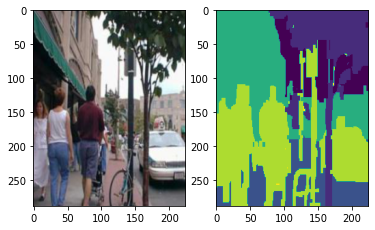

In [11]:
# You might want to look at a bunch of different images to get a feel for your data
view_image(random.randint(0, len(dataset)))

## Simple Baseline (Q2)

This is a trivial semantic segmentor. For each pixel location it computes the 
distribution of the class label in the training set and uses that as the 
prediction. In other words, if a pixel is "sky" half the time and "water" the other half in the training data, you should label it as [0.5,0,0,0,0.5,0,0,0,0].

**PDF: in your pdf report the evaluation metrics (from the next question) for this simple baseline. Also visualize the output image of simple_predict (since simple_predict outputs the same segmentation regardless of input you can just report a single image)**

In [12]:
# Question 2
def simple_train(train_dataset, train_dataloader):
    # Your code
    # -------------------------
    model = np.zeros((train_dataset.n_classes, 224, 288))
    for _, gt in train_dataset:
#         print(F.one_hot(gt[0], 9).numpy()[0].T.shape)
#         print(gt.shape)
#         print(F.one_hot(gt, 9).numpy()[0].T.shape)
        
        model += F.one_hot(gt, 9).numpy()[0].T
    count = np.sum(model, axis=0)
    print(count[0,0])
    print(sum(model[:, 0,0]))
#     572.0
#     572.0
    s = model[:,0,0]/count[0,0]
    model = model / count
    print(s)
    print(model[:, 0, 0])
#     [0.31818182 0.11888112 0.17832168 0.04370629 0.02447552 0.17832168
#      0.01223776 0.12412587 0.00174825]
#     [0.31818182 0.11888112 0.17832168 0.04370629 0.02447552 0.17832168
#      0.01223776 0.12412587 0.00174825]
    # -------------------------
    return model

def simple_predict(dataloader, model):
    gts, preds = [], []
    ## DEBUG list(dataset.classes)
    print('model.shape', model.shape)

    model = np.transpose(model, (0, 2, 1))
    for batch in dataloader:
        # Your code
        # -------------------------
        gts.extend(list(batch[1].numpy()))
        preds.extend([list(model) for _ in range(batch[0].shape[0])])
        # -------------------------
#     print(np.array(gts).shape, np.array(preds).shape)
    return np.array(gts), np.array(preds), list(dataset.classes)

In [13]:
# our "model" is class frequency, train it then make predictions for the validation set 

class_freq = simple_train(dataset, dataloader)
print('len(val_dataset)', len(val_dataset))
gts, preds, classes = simple_predict(val_dataloader, class_freq)

572
572.0
572.0
[0.46853147 0.20454545 0.         0.00699301 0.00524476 0.27622378
 0.01748252 0.01748252 0.0034965 ]
[0.46853147 0.20454545 0.         0.00699301 0.00524476 0.27622378
 0.01748252 0.01748252 0.0034965 ]
len(val_dataset) 72
model.shape (9, 224, 288)


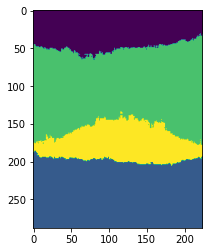

In [14]:
# visualize the output segmentation prediction
plt.imshow(np.argmax(preds[0], axis=0))

## Evaluation Metrics (Q3)

We've implemented mean average precision. Your job is to compute the confusion matrix and IoU for a set of predictions. Namely, fill in the compute_confusion_matrix function.

The **(i,j)**th entry of a confusion matrix computes the number of observations known to be in group **i** and predicted to be in group **j**. You can use [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) as a reference and sanity check.

IoU is the intersection of the predicted and ground truth segmentation masks divided by their union. Think how these values are related to what you've already computed in the confusion matrix. 

In [15]:
def segmentation_eval(gts, preds, classes, plot_file_name):
    """
    @param    gts               numpy.ndarray   ground truth labels
    @param    preds             numpy.ndarray   predicted labels
    @param    classes           string          class names
    @param    plot_file_name    string          plot file names
    """
    ious, counts = compute_confusion_matrix(gts, preds)
    aps = compute_ap(gts, preds)
    plot_results(counts, ious, aps, classes, plot_file_name)
    for i in range(len(classes)):
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(classes[i], aps[i], ious[i]))
    print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(aps), np.mean(ious)))
    return aps, ious

def plot_results(counts, ious, aps, classes, file_name):
    fig, ax = plt.subplots(1,1)
    conf = counts / np.sum(counts, 1, keepdims=True)
    conf = np.concatenate([conf, np.array(aps).reshape(-1,1), 
                           np.array(ious).reshape(-1,1)], 1)
    conf = conf * 100.
    sns.heatmap(conf, annot=True, ax=ax, fmt='3.0f') 
    arts = [] 
    # labels, title and ticks
    _ = ax.set_xlabel('Predicted labels')
    arts.append(_)
    _ = ax.set_ylabel('True labels')
    arts.append(_)
    _ = ax.set_title('Confusion Matrix, mAP: {:5.1f}, mIoU: {:5.1f}'.format(
      np.mean(aps)*100., np.mean(ious)*100.))
    arts.append(_)
    _ = ax.xaxis.set_ticklabels(classes + ['AP', 'IoU'], rotation=90)
    arts.append(_)
    _ = ax.yaxis.set_ticklabels(classes, rotation=0)
    arts.append(_)
    # fig.savefig(file_name, bbox_inches='tight')
    plt.show()

def compute_ap(gts, preds):
    aps = []
    for i in range(preds.shape[1]):
        ap, prec, rec = calc_pr(gts == i, preds[:,i:i+1,:,:])
        aps.append(ap)
    return aps

def calc_pr(gt, out, wt=None):
    gt = gt.astype(np.float64).reshape((-1,1))
    out = out.astype(np.float64).reshape((-1,1))
    tog = np.concatenate([gt, out], axis=1)*1.
    ind = np.argsort(tog[:,1], axis=0)[::-1]
    tog = tog[ind,:]
    cumsumsortgt = np.cumsum(tog[:,0])
    cumsumsortwt = np.cumsum(tog[:,0]-tog[:,0]+1)
    prec = cumsumsortgt / cumsumsortwt
    rec = cumsumsortgt / np.sum(tog[:,0])
    ap = voc_ap(rec, prec)
    return ap, rec, prec

def voc_ap(rec, prec):
    rec = rec.reshape((-1,1))
    prec = prec.reshape((-1,1))
    z = np.zeros((1,1)) 
    o = np.ones((1,1))
    mrec = np.vstack((z, rec, o))
    mpre = np.vstack((z, prec, z))

    mpre = np.maximum.accumulate(mpre[::-1])[::-1]
    I = np.where(mrec[1:] != mrec[0:-1])[0]+1;
    ap = np.sum((mrec[I] - mrec[I-1])*mpre[I])
    return ap
    
# Question 3: compute the confusion matrix and IoU metrics
# Hint: once you've computed the confusion matrix, IoU is easy
# Note: preds contains class probabilities, convert this to a class prediction
def compute_confusion_matrix(gts, preds):
    # Your code
    IoU = np.zeros((9))
    conf = np.zeros((9, 9))
#     print(gts.shape, preds.shape)
#     N = gts.shape[0] * gts.shape[1] * gts.shape[2]
#     print(type(gts))
#     print('gts.shape', gts.shape)
    
#     gts = np.transpose(gts, (0,3, 2, 1))
#     preds = np.transpose(preds, (0,3, 2, 1))
    preds = np.argmax(preds, axis=1)
    for gt, pred in zip(gts.reshape(-1).astype(int), preds.reshape(-1)):
#         print(gt)
        conf[gt][pred]+=1
    for i in range(9):
        IoU[i] = conf[i][i] / (sum(conf[i]) + sum(conf[:,i]) - conf[i][i])
    return IoU, conf
# y_true = [[2, 0, 2], [2, 0, 1]]
# y_pred = [[0, 0, 2], [2, 0, 2]]
# b = np.zeros((len(y_pred),len(y_pred[0]), 9))
# for x in range(len(y_pred)):
#     for y in range(len(y_pred[0])):
#         b[x, y, y_pred[x][y]] = 1
# # print(b)


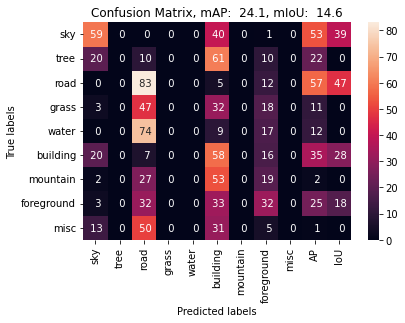

                 sky: AP: 0.53, IoU: 0.39
                tree: AP: 0.22, IoU: 0.00
                road: AP: 0.57, IoU: 0.47
               grass: AP: 0.11, IoU: 0.00
               water: AP: 0.12, IoU: 0.00
            building: AP: 0.35, IoU: 0.28
            mountain: AP: 0.02, IoU: 0.00
          foreground: AP: 0.25, IoU: 0.18
                misc: AP: 0.01, IoU: 0.00
                mean: AP: 0.24, IoU: 0.15


In [16]:
# Evaluate our trivial segmentor
aps, ious = segmentation_eval(gts, preds, classes, 'cs543-simple-train.pdf')

## Loss function (Q4)

Implement the weighted cross entropy loss. 

You may not call nn.CrossEntropy but can use it as a good reference and sanity check.

**PDF: in your pdf please describe the cross entropy loss. Also explain the purpose of using a weighted loss.**

In [154]:
# if runtime has GPU use GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print("Using device:", device)

def cross_entropy_criterion(predictions, labels, weights = torch.ones(9)):
    # your code
    #     You may not call nn.CrossEntrop
    #     torch.Size([2, 9, 288, 224])
    #     torch.Size([2, 1, 288, 224])
#     nloss = None
#     if weights is None: weights = torch.ones(9)
#     print('predictions.shape', predictions.shape)
#     print('labels.shape', labels.shape)

#     labels1 = labels.reshape((labels.shape[0], labels.shape[2], labels.shape[3]))

#     nloss = nn.CrossEntropyLoss(weight=weights)(predictions, labels1)
#     print(predictions.shape, labels.shape, len(weights))    
    predictions = F.log_softmax(predictions, dim=1)
#     predictions = torch.log(nn.Softmax(dim=1)(predictions)).permute((0,3,2,1)).reshape(-1, 9)
    weights = weights[labels]
#     weights = torch.Tensor(weights)
#     _ = F.one_hot(labels.reshape(-1), 9)
#     _ = weights*F.one_hot(labels.reshape(-1), 9)
#     print('sum', sum(weights))

    loss = - weights * predictions.gather(index=labels, dim=1)
    
    #     print(nn.Softmax(dim=1)(predictions))

#     weights = torch.as_tensor(np.array(weights)/sum(weights))
#     weights = torch.as_tensor(weights)
#     labels = weights*F.one_hot(labels.reshape(-1), 9)
#     print(labels)
#     print(predictions)
    # np.mgrid 
#     print('devices', labels.get_device(), predictions.get_device())
#     loss = -torch.sum((labels * predictions))/N
    
    loss /= weights.sum()
#     print('my loss', loss.sum(),  ' F cross', nloss)

    return loss.sum()


ts1 = torch.Tensor([[-4, 1], [3,2]])
ts2 = torch.Tensor([[0,1],[1,0]])
print(ts1 * ts2)
m = nn.Softmax(dim=0)
input = torch.Tensor([[3], [3], [3], [3]])
output = m(input)
print(output)

predictions = torch.Tensor(
[
    [
        [[3,3]],
        [[3,3]],
        [[3,3]],
        [[3,3]],
        [[3,3]],
        [[3,3]],
        [[3,3]],
        [[3,3]],
        [[3,3]],
    ],
    [
        [[3,3]],
        [[3,3]],
        [[3,3]],
        [[3,3]],
        [[3,3]],
        [[3,3]],
        [[3,3]],
        [[3,3]],
        [[3,3]],
    ],
]
)
labels = torch.LongTensor(
[
    [
        [[1,2]]
    ],
    [
        [[3,6]]
    ]
]
)

predictions = torch.Tensor(
[
    [
        [[3,3]],
        [[3,3]],
        [[-3,3]],
        [[-3,3]],
        [[-3,3]],
        [[-3,3]],
        [[-3,3]],
        [[-3,3]],
        [[-3,3]],
    ],
    [
        [[3,3]],
        [[3,3]],
        [[-3,3]],
        [[-3,3]],
        [[4,3]],
        [[-3,3]],
        [[-3,3]],
        [[-3,3]],
        [[-3,3]],
    ]
]
)
labels = torch.LongTensor(
[
    [
        [[1,2]]
    ],
    [
        [[3,6]]
    ]
]
)


# predictions = torch.Tensor(
# [
#     [
#         [[3]],
#         [[3]],
#         [[3]],
#         [[3]],
#         [[3]],
#         [[3]],
#         [[3]],
#         [[3]],
#         [[3]],
#     ]
# ]
# )
# labels = torch.LongTensor(
# [
#     [
#         [[1]]
#     ]
# ]
# )
predictions = predictions
labels = labels
# weights = torch.Tensor([0.1, 0.1, 0.1, 0.05, 0.0, 0.25, 0.2, 0.0, 0.2]).to(device)
# weights = torch.Tensor([0.1, 0.7, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).to(device)
weights =[0.1, 0.7, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
print('sum', sum(weights))
print('cross_entropy_criterion')
# print(cross_entropy_criterion(predictions, labels, weights))

# epochs = 2
# try :
#     del val_dataset
#     import gc
#     gc.collect()
# except: pass

# val_dataset = SegmentationDataset(split="val", preload=True, data_dir=DATASET_PATH, transform=False)
# val_dataloader = data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, drop_last=False)

# base_model = train(base_model, optimizer, criterion, dataloader, device, epochs=epochs)
# preds, gts = validate_model(val_dataloader, base_model, list(dataset.classes), device)
class_weights = weights
# criterion = lambda y_pred, y_true: cross_entropy_criterion(y_pred, y_true, class_weights)
# print(criterion(predictions, labels))

Using device: cuda:0
tensor([[-0., 1.],
        [3., 0.]])
tensor([[0.2500],
        [0.2500],
        [0.2500],
        [0.2500]])
sum 1.0
cross_entropy_criterion


## Training loop (Q5)

Fill in the training loop. We've provided validation code as well as skeleton code for training.

Keep in mind that you need to move data onto the device (GPU) as you cycle through the dataloader

While we've provided you with a skeleton to fill in, you should feel free to modify the visualization code for debugging purposes. For example you might want to print out the loss each iteration instead of once per epoch. Or you might want to compute validation accuracy metrics (like IoU) instead of just validation loss.

**PDF: in your pdf please describe why it is important to consider both validation and training losses simultaneously. When loss stops decreasing, can we change something about the training parameters to continue improving the model?**

In [157]:
def validate_model(val_loader, model, classes, device, show_matrix=False):
    preds = np.array([]).reshape(0,9,224,288)
    gts = np.array([]).reshape(0,1,224,288)
    with torch.no_grad():
        print('Outside loop')
        for idx, data in enumerate(val_loader):
            print(idx, 'val')
            inputs, labels = data
            inputs = inputs.to(device)

            outputs = model(inputs).cpu().numpy()
            preds = np.concatenate([preds, outputs], axis=0)
            gts = np.concatenate([gts, labels.numpy()], axis=0)
            
            print("Validating...{}\r".format(100.0*len(preds)/len(val_loader)), end="")
    
    if show_matrix:
        aps, ious = segmentation_eval(gts, preds, classes, 'cs543-simple-val_3.pdf')
    else:
        ious, counts = compute_confusion_matrix(gts, preds)
        aps = compute_ap(gts, preds)
        for i in range(len(classes)):
            print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(classes[i], aps[i], ious[i]))
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(aps), np.mean(ious)))

    return preds, gts

# Your goal is to complete this function
def train(model, optimizer, criterion, trainloader, device, valloader = None, epochs=15):
    import copy
    train_loss_over_epochs = []
    val_loss_over_epochs = []
    plt.ioff()
    fig = plt.figure()
    best_loss = None
    best_model = copy.deepcopy(model)
    try:
        for epoch in range(epochs):
            # running loss is the **average** loss for each item in the dataset during this epoch
            running_loss = 0.0

            for i, data in enumerate(trainloader, 0):
                # Your code
                # -------------------------
                inputs, labels = data
    #             print(type(labels))
                inputs = inputs.to(device)
                outputs = model(inputs).cpu()
#                 loss =  cross_entropy_criterion(outputs, labels)
                loss =  criterion(outputs, labels)
                running_loss+= loss.item()
                ## backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # -------------------------
            running_loss /= len(trainloader)
            if valloader is None:
                if best_loss is None or running_loss < best_loss:
                    best_loss, best_model =running_loss, copy.deepcopy(model)
                
            train_loss_over_epochs.append(running_loss)
            # Note: it can be more readable to overwrite the previous line - end="\r"
            print('Epoch: {}, training loss: {:.3f}'.format(epoch + 1, running_loss))


            # If you pass in a validation dataloader then compute the validation loss
            if not valloader is None:
                val_loss = 0.0
                with torch.no_grad():
                    for data in valloader:
                        # Your code
                        # -------------------------
                        inputs, labels = data
                        inputs = inputs.to(device)
                        outputs = model(inputs).cpu()
                        loss =  criterion(outputs, labels)
#                         loss =  cross_entropy_criterion(outputs, labels)
                        val_loss+= loss.item()
                    val_loss /= len(valloader)
                        # -------------------------
                val_loss_over_epochs.append(val_loss)
                if best_loss is None or val_loss < best_loss:
                    best_loss, best_model = val_loss, copy.deepcopy(model)
                print('Epoch: {}, validation loss: {:.3f}'.format(epoch + 1, val_loss))
    except KeyboardInterrupt:
        print('Finished', epoch+1 , 'epochs')
    except:
        import traceback
        traceback.print_exc()
            
    plt.subplot(2, 1, 1)
    plt.ylabel('Loss')
    plt.plot(np.arange(len(train_loss_over_epochs)), train_loss_over_epochs, color='red', label='train')
    print(not valloader is None)
    if not valloader is None:
        plt.plot(np.arange(len(val_loss_over_epochs)), val_loss_over_epochs, color='blue', label='val')
    plt.title('Loss per Epoch')
#     plt.xticks(np.arange(epochs, dtype=int))
    plt.xticks(np.arange(len(train_loss_over_epochs), dtype=int))
    plt.grid(True)
    plt.legend()
    plt.show()
#     return model
    return best_model



## Model definitions (Q6)

Now create your models. Create one basic Convolutional architecture and one U-Net architecture.

We provide some helpful methods below to compute the size of your next convolutional layer (you can find these formula at TODO).

Some things to keep in mind:
- your basic layer is nn.Conv2D, read its documentation
- for UNet you will also need nn.ConvTranspose2D and Pooling layers
- nn.BatchNorm2d is incredibly helpful between layers
- you can stick to ReLU activations, but are welcome to report results with other activation functions
- the model output should be class probabilities

**PDF: in your pdf please describe your final model architectures. Report the training plots and final accuracy metrics on the validation set for each model. What batch size, learning rate, optimizer did you find works best. Perform a small ablation study: what is the effect of batchnorm on training speed and accuracy? Visualize a few images and their predicted segmentation masks by your UNet model.**

In [19]:
def conv_out_size(inp_size, kernel_size, dilation, padding, stride):
    return ((inp_size + 2*padding - dilation * (kernel_size - 1) - 1) // stride) + 1

def conv_trans_out_size(inp_size, kernel_size, dilation, padding, stride, out_padding):
    return (inp_size - 1) * stride - 2*padding + dilation * (kernel_size - 1) + out_padding + 1

### Now we can finally train our models...

In [ ]:
# if runtime has GPU use GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print("Using device:", device)

In [ ]:
# For the weighted cross entropy loss we can compute class weights using our simple baseline
class_freq = simple_train(dataset, dataloader)
class_weights = []
for i in range(9):
    class_weights.append(1 / np.mean(class_freq[i, :, :]))
print(class_weights)

### Basic convolutional model training

In [ ]:
class BaseConv(nn.Module):
    def __init__(self, in_channels=3):
        super(BaseConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, 3, 1, 1, bias=False)
        self.conv2 = nn.Conv2d(16, 9, 3, 1, 1, bias=False)
        
        

        
    def forward(self, x):
        original_shape = x.shape
#         print(x.shape)
        x = self.conv1(x)
#         print(x.shape)
        x = self.conv2(x)
#         print(x.shape)
        assert((x.shape[1], x.shape[2], x.shape[3]) == (9, original_shape[2], original_shape[3]))
        
        return x

In [ ]:
# First make the model and put it on the device
base_model = BaseConv().to(device)

# Now define our loss criterion as cross entropy based on your previous code
#criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
criterion = lambda y_pred, y_true: cross_entropy_criterion(y_pred, y_true, class_weights)

# Now make our optimizer for this model
# TODO: pick an optimizer from torch.optim and set the learning rate
lr = 0.01
optimizer = torch.optim.SGD(base_model.parameters(), lr=lr)


In [ ]:
# Now train and validate
# Consider putting this code into a loop, 
# thus alternating between training for some number of epochs and validating

# TODO: how many epochs to train for?
epochs = 20
base_model = train(base_model, optimizer, criterion, dataloader, device, val_dataloader, epochs=epochs)
preds, gts = validate_model(val_dataloader, base_model, list(dataset.classes), device, True)

#### UNet model training

In [97]:
class DoubleConv(nn.Module):
    # The convolutoin components that keep the original size of the images
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # kernel size 3, padding 1
            # [(W−K+2P)/S]+1
            # [(W-3+2x1)]+1 = W
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            # Set the bias to false since bias is going to be offset by BatchNorm2d
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # [(W-3+2)]+1 = W
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=9
    ):
        super(UNet, self).__init__()
        dims =[8, 16, 32, 64]
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        # Max pooling (W - F) / S + 1
        # (W - 2) / 2 + 1 = W / 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down-sampling
        self.downs.append(DoubleConv(in_channels, dims[0]))
        for i in range(1, len(dims)):
            self.downs.append(DoubleConv(dims[i-1], dims[i]))

        # upsampling
        for dim in reversed(dims):
            self.ups.append(
                # Lout​=(Lin​−1)×stride−2×padding+dilation[1]×(kernel_size−1)+output_padding+1
                # Lout = (Lin - 1)x2 - + 1x(2-1) + 1 = 2 x Lin
                nn.ConvTranspose2d(
                    dim*2, dim, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(dim*2, dim))

        self.bottleneck = DoubleConv(dims[-1], dims[-1]*2)
        self.final_conv = nn.Conv2d(dims[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections.reverse()
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        return self.final_conv(x)

In [98]:
model_unet = UNet().to(device)

Epoch: 1, training loss: 2.298
True


Traceback (most recent call last):
  File "<ipython-input-95-576dc14f851f>", line 84, in train
    best_loss, best_model = copy.deepcopy(model)
TypeError: cannot unpack non-iterable UNet object


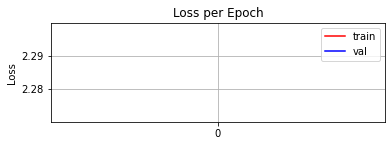

Outside loop
0 val
1 valating...320.0
2 valating...640.0
3 valating...960.0
4 valating...1280.0


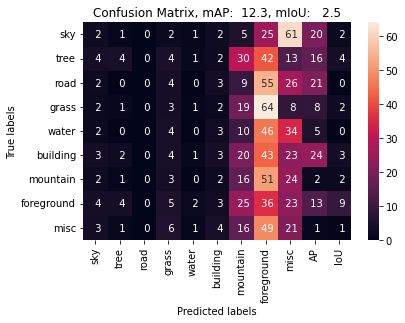

                 sky: AP: 0.20, IoU: 0.02
                tree: AP: 0.16, IoU: 0.04
                road: AP: 0.21, IoU: 0.00
               grass: AP: 0.08, IoU: 0.02
               water: AP: 0.05, IoU: 0.00
            building: AP: 0.24, IoU: 0.03
            mountain: AP: 0.02, IoU: 0.02
          foreground: AP: 0.13, IoU: 0.09
                misc: AP: 0.01, IoU: 0.01
                mean: AP: 0.12, IoU: 0.03
CPU times: user 3min 32s, sys: 13.8 s, total: 3min 45s
Wall time: 23.2 s


In [99]:
%%time


# TODO: fill in this code as you did above for the basic convolutional model
criterion = lambda y_pred, y_true: cross_entropy_criterion(y_pred, y_true, class_weights)
# criterion = lambda y_pred, y_true: cross_entropy_criterion(y_pred, y_true, class_weights)

epochs = 60
lr = 0.0001
optimizer = torch.optim.SGD(model_unet.parameters(), lr=lr)
model_unet = train(model_unet, optimizer, criterion, dataloader, device,val_dataloader, epochs=epochs)
preds, gts = validate_model(val_dataloader, model_unet, list(dataset.classes), device, True)

Make sure to report the results for both models. 

## Working off a pretrained model (Q7)

Finally, you will now modify a pretrained model (resnet18) and use it as an initialization for training. You should be able to get better results with this model than before.

You can finetune (meaning backpropagate through the resnet layers) or not. You can finetune just some layers and not others. It's up to you.

**PDF: in your pdf report the final accuracy of your model based on a pretrained model. Describe how you used the pretrained model, which features did you extract and why?**

In [23]:
pretrained_resnet = models.resnet18(pretrained=True)
# print(pretrained_resnet)
print(len(list(pretrained_resnet.children())))

10


In [145]:
# https://medium.com/the-owl/extracting-features-from-an-intermediate-layer-of-a-pretrained-model-in-pytorch-easy-way-62631c7fa8f6
class DoubleConv(nn.Module):
    # The double convolution modules
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # kernel size 3, padding 1
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            # Set the bias to false since bias is going to be offset by BatchNorm2d
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UpPool(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpPool, self).__init__()
        self.tranconv = nn.Sequential (
            nn.ConvTranspose2d(
                    in_channels, out_channels, kernel_size=2, stride=2,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.tranconv(x)
    
    
class ResnetBasedModel(nn.Module):
    
    def __init__(self, pretrained_resnet, num_layers_to_remove=4):
        super(ResnetBasedModel, self).__init__()
        # You can, for example, extract the first N layers of the model like this:
        # self.resnet_features = nn.Sequential(*list(pretrained_resnet.children())[:N])
        # 10 layers in total and the first 8 layers are for feature extraction 
        self.resnet_features = nn.Sequential(*list(pretrained_resnet.children())[:-num_layers_to_remove])
        self.decoder = nn.ModuleList()
        
        for param in self.resnet_features.parameters():
             param.requires_grad = False

        
        
        dims =[64, 128]
#         dims =[16, 32, 64, 128]
        
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down-sampling
        self.downs.append(DoubleConv(128, dims[0]))
        for i in range(1, len(dims)):
            self.downs.append(DoubleConv(dims[i-1], dims[i]))

        # upsampling
        for dim in reversed(dims):
            self.ups.append(
                UpPool(dim*2, dim)
                #                 nn.ConvTranspose2d(
#                     dim*2, dim, kernel_size=2, stride=2,
#                 )
            )
            self.ups.append(DoubleConv(dim*2, dim))

        self.bottleneck = DoubleConv(dims[-1], dims[-1]*2)
        
        self.upsamples = nn.ModuleList()
        self.upsamples.append(
            UpPool(64, 64)
        )
        self.upsamples.append(
            UpPool(64, 32)
        )

        self.upsamples.append(
            UpPool(32, 16)
        )
        self.final_conv = DoubleConv(16, 9)

        
    def forward(self, x):
        skip_connections = []

        original_size = x.shape
        x = self.resnet_features(x)
        
        for idx, down in enumerate(self.downs):
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            
        x = self.bottleneck(x)
#         print('after bpttleneck', x.shape)
        skip_connections.reverse()
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        for upsample in self.upsamples:
            x = upsample(x)
        x = self.final_conv(x)
        return x


In [146]:
resnet_based_model = ResnetBasedModel(pretrained_resnet).to(device)

Epoch: 1, training loss: 0.744
Epoch: 1, validation loss: 0.667
Epoch: 2, training loss: 0.730
Epoch: 2, validation loss: 0.675
Epoch: 3, training loss: 0.707
Epoch: 3, validation loss: 0.672
Epoch: 4, training loss: 0.705
Epoch: 4, validation loss: 0.661
Epoch: 5, training loss: 0.699
Epoch: 5, validation loss: 0.658
Epoch: 6, training loss: 0.697
Epoch: 6, validation loss: 0.658
Epoch: 7, training loss: 0.679
Epoch: 7, validation loss: 0.649
Epoch: 8, training loss: 0.686
Epoch: 8, validation loss: 0.669
Epoch: 9, training loss: 0.690
Epoch: 9, validation loss: 0.654
Epoch: 10, training loss: 0.670
Epoch: 10, validation loss: 0.648
Epoch: 11, training loss: 0.669
Epoch: 11, validation loss: 0.645
Epoch: 12, training loss: 0.671
Epoch: 12, validation loss: 0.638
Epoch: 13, training loss: 0.664
Epoch: 13, validation loss: 0.634
Epoch: 14, training loss: 0.663
Epoch: 14, validation loss: 0.637
Epoch: 15, training loss: 0.647
Epoch: 15, validation loss: 0.628
Epoch: 16, training loss: 0.

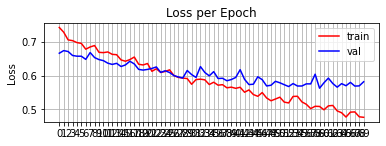

Outside loop
0 val
1 valating...320.0
2 valating...640.0
3 valating...960.0
4 valating...1280.0


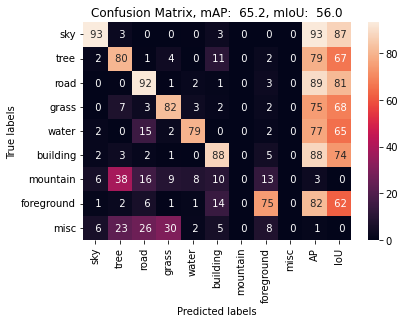

                 sky: AP: 0.93, IoU: 0.87
                tree: AP: 0.79, IoU: 0.67
                road: AP: 0.89, IoU: 0.81
               grass: AP: 0.75, IoU: 0.68
               water: AP: 0.77, IoU: 0.65
            building: AP: 0.88, IoU: 0.74
            mountain: AP: 0.03, IoU: 0.00
          foreground: AP: 0.82, IoU: 0.62
                misc: AP: 0.01, IoU: 0.00
                mean: AP: 0.65, IoU: 0.56


In [156]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = optim.Adam(resnet_based_model.parameters(), lr=0.0005)

resnet_based_model = train(resnet_based_model, optimizer, criterion, dataloader, device, val_dataloader,epochs=70)
preds, gts = validate_model(val_dataloader, resnet_based_model, list(dataset.classes), device, True)

# Test set

Finally we can check evaluation on test set....

**PDF: in your pdf report the results of your best model (this should be based on a pretrained model) on the test dataset.**

Outside loop
0 val
1 valating...320.0
2 valating...640.0
3 valating...960.0
4 valating...1280.0


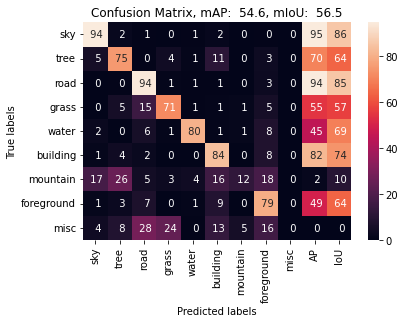

                 sky: AP: 0.95, IoU: 0.86
                tree: AP: 0.70, IoU: 0.64
                road: AP: 0.94, IoU: 0.85
               grass: AP: 0.55, IoU: 0.57
               water: AP: 0.45, IoU: 0.69
            building: AP: 0.82, IoU: 0.74
            mountain: AP: 0.02, IoU: 0.10
          foreground: AP: 0.49, IoU: 0.64
                misc: AP: 0.00, IoU: 0.00
                mean: AP: 0.55, IoU: 0.56


In [69]:
test_dataset = SegmentationDataset(split="test", preload=True, data_dir=DATASET_PATH, transform=False)
test_dataloader = data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, drop_last=False)
preds, gts = validate_model(test_dataloader, resnet_based_model, list(dataset.classes), device, True)